In [13]:
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print(f"Number of original training examples: {len(x_train)}, shape: {np.shape(x_train)}")
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000, shape: (60000, 28, 28, 1)
Number of original test examples: 10000


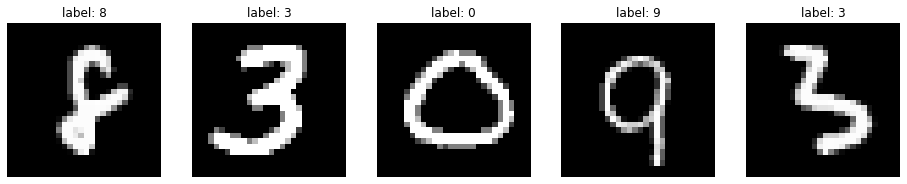

In [10]:
figure = plt.figure(figsize=(16, 10))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = rng.integers(len(x_train), size=(1,)).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f'label: {y_train[sample_idx]}')
    plt.axis("off")
    plt.imshow(x_train[sample_idx].squeeze(), cmap="gray")
plt.show()

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(10, (5,5), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(20, (5,5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
print(model.output_shape)
print(model.summary())

(None, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 20)          0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 20)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 320)   

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.2315 - accuracy: 0.9310 - val_loss: 0.0733 - val_accuracy: 0.9828
Epoch 2/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.1534 - accuracy: 0.9547 - val_loss: 0.0538 - val_accuracy: 0.9875
Epoch 3/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1251 - accuracy: 0.9631 - val_loss: 0.0485 - val_accuracy: 0.9876
Epoch 4/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1093 - accuracy: 0.9678 - val_loss: 0.0381 - val_accuracy: 0.9904
Epoch 5/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0999 - accuracy: 0.9711 - val_loss: 0.0368 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0935 - accuracy: 0.9726 - val_loss: 0.0336 - val_accuracy: 0.9905
Epoch 7/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0876 - accuracy: 0.9748 - val_loss: 0.0310 -

313/313 - 2s - loss: 0.0298 - accuracy: 0.9917 - 2s/epoch - 6ms/step
Test accuracy: 0.9916999936103821


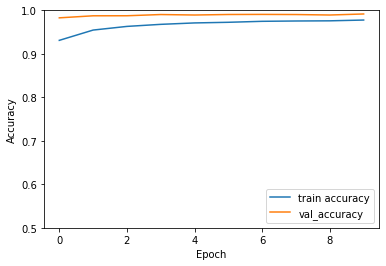

In [19]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

In [20]:
tf_path = os.path.join('models', 'mnist_tf_pretrained')
tf.saved_model.save(model, tf_path)

INFO:tensorflow:Assets written to: models\mnist_tf_pretrained\assets


In [26]:
!python3 -m tf2onnx.convert --saved-model ./models/mnist_tf_pretrained --output ./models/mnist_onnx_from_tf.onnx

2022-04-24 15:14:43.114655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-24 15:14:43.114745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-24 15:15:04.574630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-24 15:15:04.574879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-04-24 15:15:04.575084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-04-24 15:15:04.575284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

In [27]:
import torch
# use external onnx to torch conversion tool
from onnx2torch.converter import convert

onnx_path = os.path.join('models', 'mnist_onnx.onnx')
torch_model = convert(onnx_path)

print(torch_model)

GraphModule(
  (Conv_0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (MaxPool_0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Relu_0): ReLU()
  (Conv_1): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (MaxPool_1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Relu_1): ReLU()
  (Constant_0): OnnxConstant()
  (Reshape_0): OnnxReshape()
  (Gemm_0): Linear(in_features=320, out_features=50, bias=True)
  (Relu_2): ReLU()
  (Gemm_1): Linear(in_features=50, out_features=10, bias=True)
  (LogSoftmax_0): OnnxSoftmaxV1V11()
)



def forward(self, input_1):
    conv_0 = self.Conv_0(input_1);  input_1 = None
    max_pool_0 = self.MaxPool_0(conv_0);  conv_0 = None
    relu_0 = self.Relu_0(max_pool_0);  max_pool_0 = None
    conv_1 = self.Conv_1(relu_0);  relu_0 = None
    max_pool_1 = self.MaxPool_1(conv_1);  conv_1 = None
    relu_1 = self.Relu_1(max_pool_1);  max_pool_1 = None
    constant_0

ConcreteFunction signature_wrapper(*, conv2d_4_input)
  Args:
    conv2d_4_input: float32 Tensor, shape=(None, 28, 28, 1)
  Returns:
    {'dense_1': <1>}
      <1>: float32 Tensor, shape=(None, 10)
<class 'tensorflow.python.saved_model.load._WrapperFunction'>


In [38]:
for name, param in torch_model.named_parameters():
    print(name)
    print(type(param))
    print(param.data.size())
    print('------------------')

AttributeError: '_UserObject' object has no attribute 'layers'

In [31]:

torch_output = torch_model(torch.from_numpy(x_train[0]))
print(torch_output)

figure = plt.figure(figsize=(16, 10))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = rng.integers(len(x_train), size=(1,)).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f'label: {y_train[sample_idx]}')
    plt.axis("off")
    plt.imshow(x_train[sample_idx].squeeze(), cmap="gray")
plt.show()

RuntimeError: Given groups=1, weight of size [10, 1, 5, 5], expected input[1, 28, 28, 1] to have 1 channels, but got 28 channels instead